# File Ingestion

## Setup

Using local config file (see [01_pipeline](./01_pipeline.ipynb))

In [1]:
# import os
# import datajoint as dj;
# # change to the upper level folder to detect dj_local_conf.json
# if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
# assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
# from adamacs.pipeline import subject, behavior, session, event, trial

In [2]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()
from adamacs.pipeline import subject, behavior, session, event, trial


[2023-07-19 10:16:39,097][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-07-19 10:16:39,139][INFO]: Connected tobiasr@172.26.128.53:3306


Manual entry

### BPod Path Setup

Your `dj.config` file should have a section for your BPod root directory under `custom`: `exp_root_data_dir`. This is a list of one or more paths where the ingestion tool will look for the relative paths it is given.

In [3]:
import datajoint as dj
from element_interface.utils import find_full_path
from adamacs.pipeline import session, event, trial
from adamacs.ingest.bpod import Bpodfile
from adamacs.paths import get_experiment_root_data_dir

bpod_path = "DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat"
# bpod_path = "TR_WEZ-8701_2023-01-13_scan9FG1THFD_sess9FG1TAXY/scan9FG1THFD_WEZ-8701_StimArenaMaster_20230113_172307.mat"

root_dirs = dj.config["custom"]["exp_root_data_dir"]
bpod_path_full = find_full_path(get_experiment_root_data_dir(),bpod_path)

print(f"Root: {root_dirs}\nFull: {bpod_path_full}")

Root: ['/datajoint-data/data/tobiasr']
Full: /datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat


### Initial check of tables

In [4]:
# from adamacs.pipeline import session, event, trial

# session.Session.delete()


# print('Sessions:', len(session.Session()))
# print('Trials  :', len(trial.Trial()))
# print('Events  :', len(event.Event()))

In [6]:
# event.EventType.delete()

In [8]:
event.BehaviorRecording

session_id,scan_id,recording_start_time,recording_duration,recording_notes
sess9FJ4IJOQ,scan9FJ4IJOQ,2023-07-18 15:25:56,860.0,


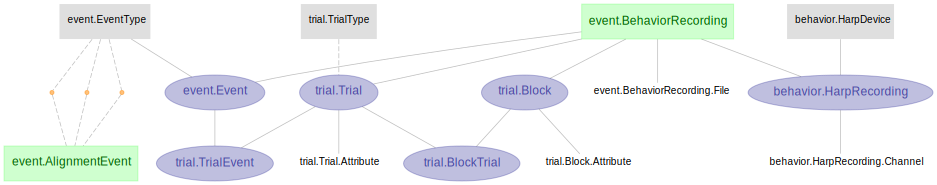

In [7]:
dj.Diagram(behavior)+dj.Diagram(event)+dj.Diagram(trial)

## Automated BPod ingestion

The function is designed ask for a confirmation before entered into the schema.

In [9]:
# bpod_path = "DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat"
root_dirs = dj.config["custom"]["exp_root_data_dir"]
bpod_object = Bpodfile(bpod_path)
bpod_object.ingest()


Subject does not yet exist.Attempting pyrat import: WEZ-8701
Connected
Found no live entries for WEZ-8701. Testing sacrificed.
Gathering users...
Gathering protocols...
Gathering lines/mutations...
Gathering subjects...
--- PyRAT items to be inserted ---
User(s):  [] 

Protocol(s):  [] 

Line(s):  [] 

Mutation(s):  [] 

Subjects:  ['WEZ-8701'] 



TypeError: can only concatenate str (not "int") to str

In [10]:
subject.Subject()

subject PyRat import uses this for earmark value,earmark,sex Geschlecht,birth_date Geb.,death_date Gest.,generation Generation (F2 in example sheet),parent_ids dict of parent_sex: parent_eartag,owner_id,responsible_id,line strain_id within PyRAT. Not name_id seen in GUI,protocol
ROS-1518,T581,M,2023-01-04T00:00:00,None,F6 d,=BLOB=,1,2,376,81-02.04.2022.A427
WEZ-8701,T453,M,2021-10-19T00:00:00,2022-09-19T19:51:53,,=BLOB=,1,2,376,01_Organentnahme


Check that insertion worked:

In [11]:
trial.TrialEvent & 'trial_id=0'

session_id,scan_id,trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start


In [ ]:
trial.

In [ ]:
event.EventType()

We can also interact with bpod objects. For example:

In [ ]:
bpod_object.trial(1).attributes

In [ ]:
bpod_object.trial_data

# Add Harp recording

In [12]:
from adamacs.pipeline import behavior, event, scan
event_recording = event.BehaviorRecording.fetch('KEY')[0]
behavior.HarpRecording()

session_id,scan_id,harp_device_id


In [13]:
scansi = "scan9FB2LN5C"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
harp_paths = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*harp*bin"))

IndexError: list index out of range

In [14]:
event.BehaviorRecording.File()

session_id,scan_id,filepath
sess9FJ4IJOQ,scan9FJ4IJOQ,/datajoint-data/data/tobiasr/LE_ROS-1518_2023-07-18_scan9FJ4IJOQ_sess9FJ4IJOQ/scan9FJ4IJOQ_LE_ROS-test_0003.h5


In [14]:
bpod_path_relative

'/datajoint-data/data/tobiasr/LE_ROS-1518_2023-05-17_scan9FI3LVI8_sess9FI3LVI8/scan9FI3LVI8_LE_ROS-1518_2030.h5'

In [9]:
bpod_path_relative 

'/datajoint-data/data/tobiasr/LE_ROS-1518_2023-05-17_scan9FI3LVI8_sess9FI3LVI8/scan9FI3LVI8_LE_ROS-1518_2030.h5'

In [ ]:
behavior.HarpRecording.populate()

In [ ]:
behavior.HarpRecording.Channel()